In [1]:
import numpy as np

from scipy.ndimage import gaussian_filter1d, convolve1d
from scipy import convolve

import matplotlib.pyplot as plt

from crispy.utils import calculate_bin_edges

In [80]:
plt.rcParams["figure.dpi"] = 200
plt.rcParams["font.size"] = 5
plt.rcParams["figure.figsize"] = [8, 5]
plt.rcParams["font.family"] = "sans-serif"
# plt.rcParams["font.sans-serif"] = ["Computer Modern Sans Serif"]

In [81]:
def get_earth_reflect_spectrum():
    """
    Get the geometric albedo spectrum of the Earth around the Sun.
    This was produced by Tyler Robinson using the VPL Earth Model
    (Robinson et al., 2011)
    Returns
    -------
    lamhr : numpy.ndarray
    Ahr : numpy.ndarray
    fstar : numpy.ndarray
    """

    fn = 'earth_quadrature_radiance_refl.dat.txt'
    model = np.loadtxt(fn, skiprows=8)
    lamhr = model[:,0]
    radhr = model[:,1]
    fstar = model[:,2]
    reflhr = model[:,3]
    Ahr   = np.pi*(np.pi*radhr/fstar) # hi-resolution reflectivity
    return lamhr, Ahr, fstar

In [348]:
lam, albedo, _ = get_earth_reflect_spectrum()
lam *= 1000

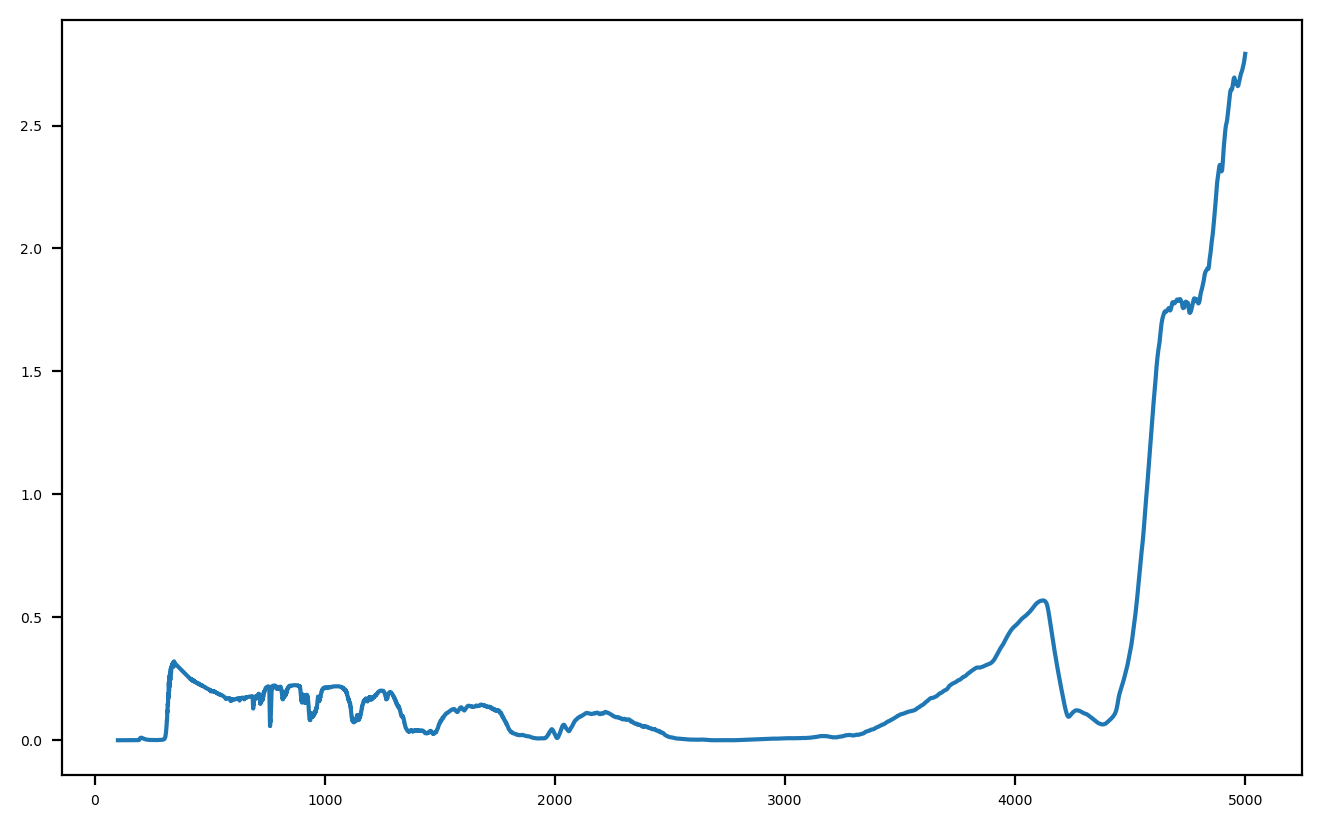

In [83]:
plt.figure()
plt.plot(lam, albedo)
plt.show()
# plt.plot(lam1, albedo1)
# plt.xlim([680, 840])

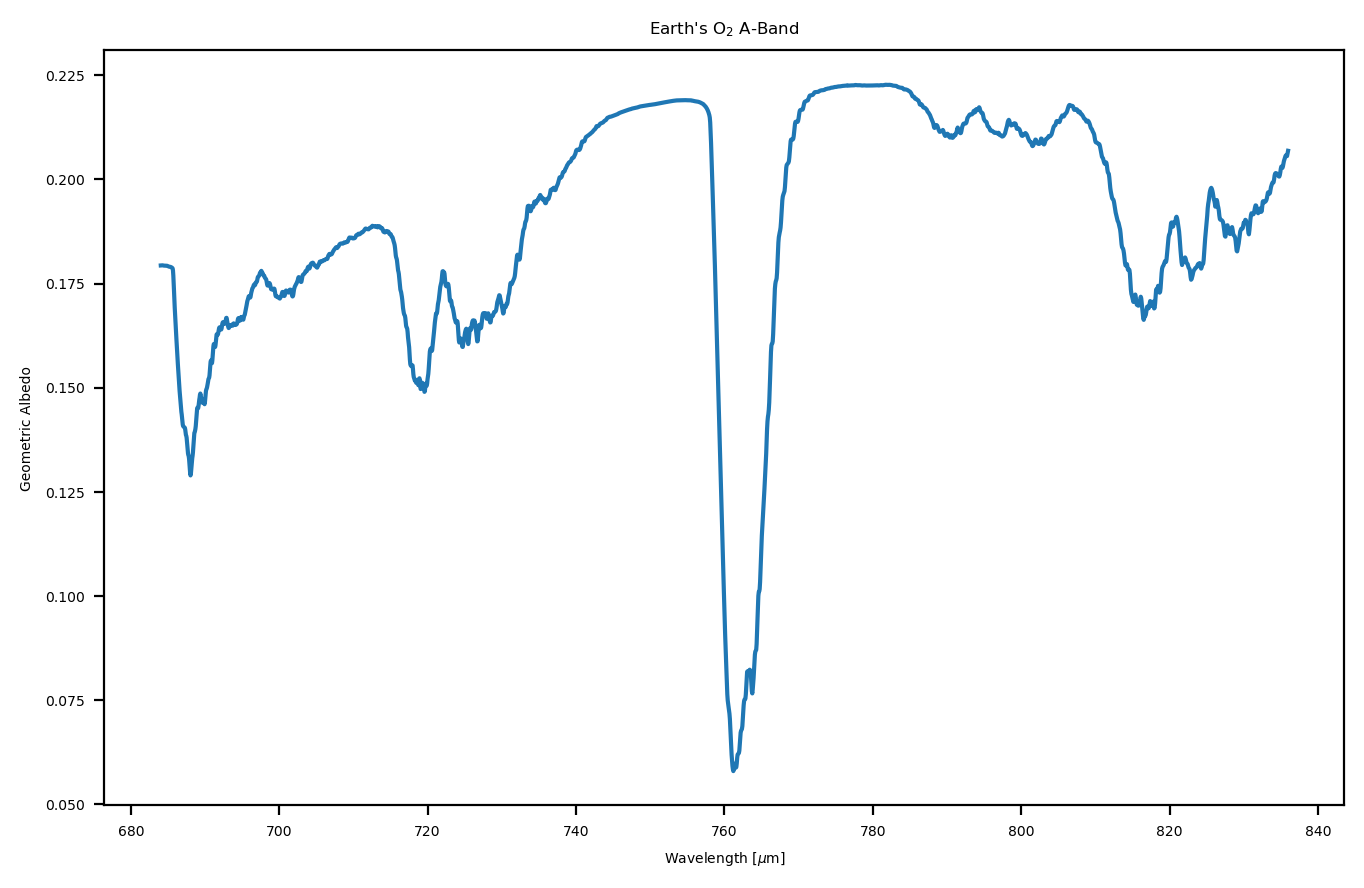

In [397]:
lammin = 750.0#684.0
lammax = 775.0#836.0
lammin = 684.0 
lammax = 836.0 

# Create a wavelength mask
m = (lam > lammin) & (lam < lammax)

# Plot the band
plt.plot(lam[m], albedo[m])
plt.xlabel(r"Wavelength [$\mu$m]")
plt.ylabel("Geometric Albedo")
plt.title(r"Earth's O$_2$ A-Band")
plt.show()

In [398]:
def construct_lam(lammin, lammax, Res=None, dlam=None):
    # Keyword catching logic
    goR = False
    goL = False
    if ((Res is None) and (dlam is None)) or (Res is not None) and (dlam is not None):
        print("Error in construct_lam: Must specify either Res or dlam, but not both")
    elif Res is not None:
        goR = True
    elif dlam is not None:
        goL = True
    else:
        print("Error in construct_lam: Should not enter this else statment! :)")
        return None, None

    # If Res is provided, generate equal resolving power wavelength grid
    if goR:

        # Set wavelength grid
        dlam0 = lammin/Res
        dlam1 = lammax/Res
        lam  = lammin #in [um]
        Nlam = 1
        while (lam < lammax + dlam1):
            lam  = lam + lam/Res
            Nlam +=1
        lam    = np.zeros(Nlam)
        lam[0] = lammin
        for j in range(1,Nlam):
            lam[j] = lam[j-1] + lam[j-1]/Res
        Nlam = len(lam)
        dlam = np.zeros(Nlam) #grid widths (um)
#         print(lam)
        # Set wavelength widths
        for j in range(1,Nlam-1):
            dlam[j] = 0.5*(lam[j+1]+lam[j]) - 0.5*(lam[j-1]+lam[j])

        #Set edges to be same as neighbor
        dlam[0] = dlam0#dlam[1]
        dlam[Nlam-1] = dlam1#dlam[Nlam-2]

        lam = lam[:-1]
        dlam = dlam[:-1]

    # If dlam is provided, generate evenly spaced grid
    if goL:
        lam = np.arange(lammin, lammax+dlam, dlam)
        dlam = dlam + np.zeros_like(lam)

    return lam, dlam

In [399]:
def construct_lam_ifs(lammin, lammax, R, verbose=True):
     
    log_lammin = np.log(float(lammin)).astype(np.float64)
    log_lammax = np.log(float(lammax))
    Nspec = int(np.log(lammax/lammin) * R) + 1
    
    dloglam = (log_lammax - log_lammin) / Nspec
    
    if verbose:
        print('Reduced cube will have %d wavelength bins' % (Nspec))
#     print(np.exp(log_lammin))
#     print(np.exp(log_lammax))
    
#     loglam_midpts = np.arange(log_lammin, log_lammax + dloglam, dloglam)
#     loglam_endpts = calculate_bin_edges(loglam_midpts)
    loglam_midpts = np.linspace(log_lammin, log_lammax, Nspec)
    loglam_endpts = calculate_bin_edges(loglam_midpts)
    
#     loglam_endpts = np.linspace(log_lammin, log_lammax, Nspec)
#     loglam_midpts = (loglam_endpts[1:] + loglam_endpts[:-1]) / 2
    lam_endpts = np.exp(loglam_endpts)
    lam_midpts = np.exp(loglam_midpts)
    
#     print(lam_midpts.size, lam_midpts[:-1] / np.diff(lam_midpts))
#     dlam = (lammax - lammin) / Nspec
#     lam_midpts = np.arange(lammin, lammax + dlam, dlam)
#     lam_endpts = calculate_bin_edges(lam_midpts)
    return lam_midpts, lam_endpts

In [400]:
from scipy.stats import binned_statistic
def downbin_spec(specHR, lamHR, lamLR, dlam=None):

    if dlam is None:
        ValueError("Please supply dlam in downbin_spec()")

    # Reverse ordering if wl vector is decreasing with index
    if len(lamLR) > 1:
        if lamHR[0] > lamHR[1]:
            lamHI = np.array(lamHR[::-1])
            spec = np.array(specHR[::-1])
        if lamLR[0] > lamLR[1]:
            lamLO = np.array(lamLR[::-1])
            dlamLO = np.array(dlam[::-1])

    # Calculate bin edges
    LRedges = np.hstack([lamLR - 0.5*dlam, lamLR[-1]+0.5*dlam[-1]])

    # Call scipy.stats.binned_statistic()
    specLR = binned_statistic(lamHR, specHR, statistic="mean", bins=LRedges)[0]

    return specLR

In [401]:
def downbin_spec_ifs(lam_new, lam_bins, spec):
    # Call scipy.stats.binned_statistic()
    spec_new = binned_statistic(lam_new, spec, statistic="mean", bins=lam_bins)[0]
    return spec_new

In [402]:
# define set of resolving powers
R = np.array([1, 10, 30, 70, 100, 150, 200, 500, 1000])
# R = np.arange(70, 190, 20)

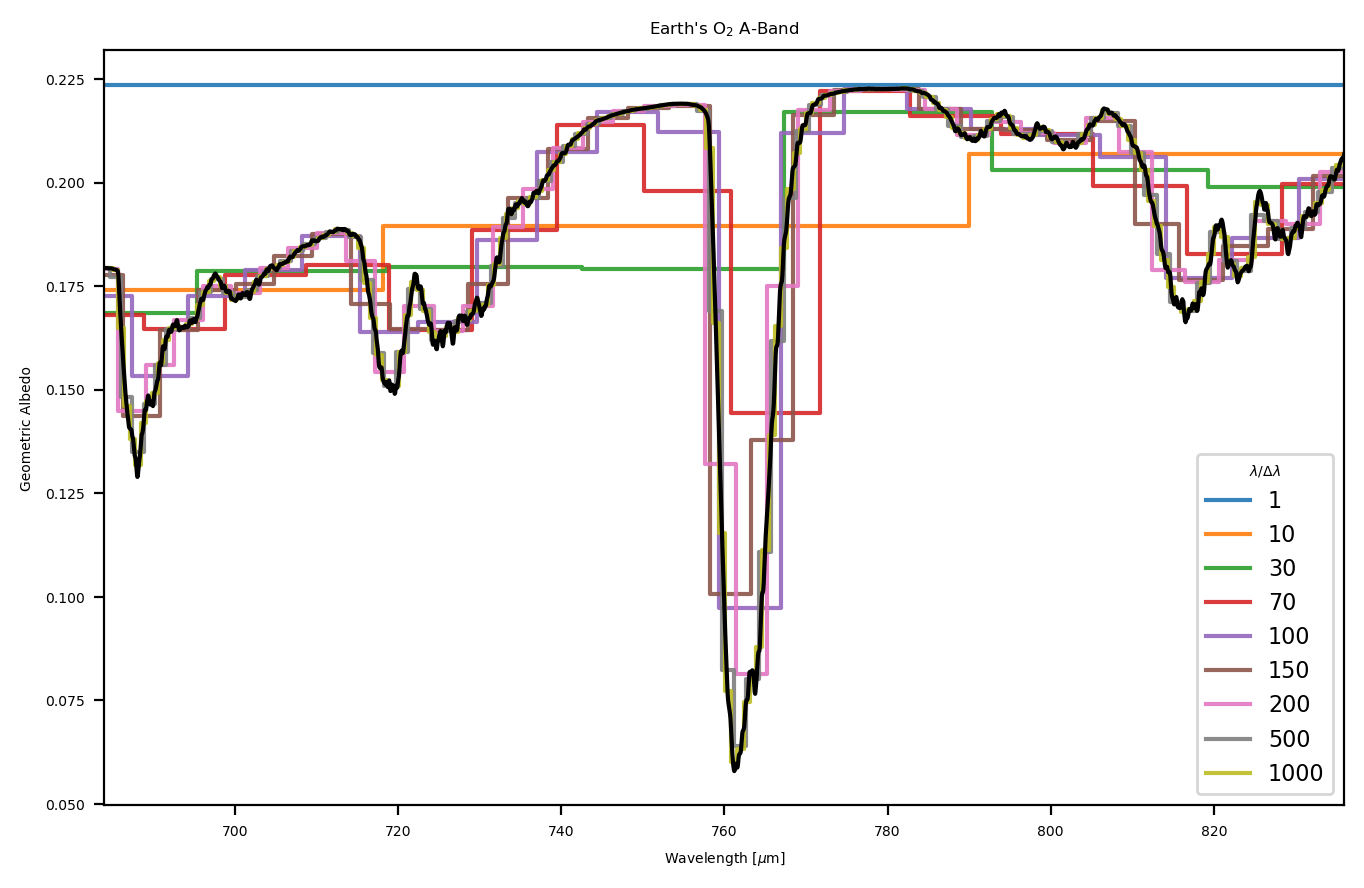

In [403]:
ifs = False
bottom_val = np.zeros(len(R))

# Loop over R
for i, r in enumerate(R):

    
    if ifs:
        wl, dwl = construct_lam_ifs(lammin, lammax, r, verbose=False)
#         print(wl.size, dwl.size)
        Alr = downbin_spec_ifs(lam, dwl, albedo)
    else:                               
        # Construct new low-res wavelength grid
        wl, dwl = construct_lam(lammin, lammax, r)
        #     print(wl)
        # Down-bin flux to low-res
        Alr = downbin_spec(albedo,lam, wl, dlam=dwl)

    # Plot
#     plt.step(wl, Alr, where="mid", alpha = 0.5, color=f"C{i}", label = "%i" %r)
    plt.plot(wl, Alr, drawstyle='steps-mid', alpha = 0.9, color=f"C{i}", label = "%i" %r)
#     plt.scatter(wl, Alr, color=f"C{i}")

    # Save bottom value
    bottom_val[i] = np.min(Alr)

# Finsh plot
plt.plot(lam[m], albedo[m], c = "k")
plt.xlim(lammin, lammax)
plt.legend(fontsize = 8, title = r"$\lambda / \Delta \lambda$")
plt.xlabel(r"Wavelength [$\mu$m]")
plt.ylabel("Geometric Albedo")
plt.title(r"Earth's O$_2$ A-Band");

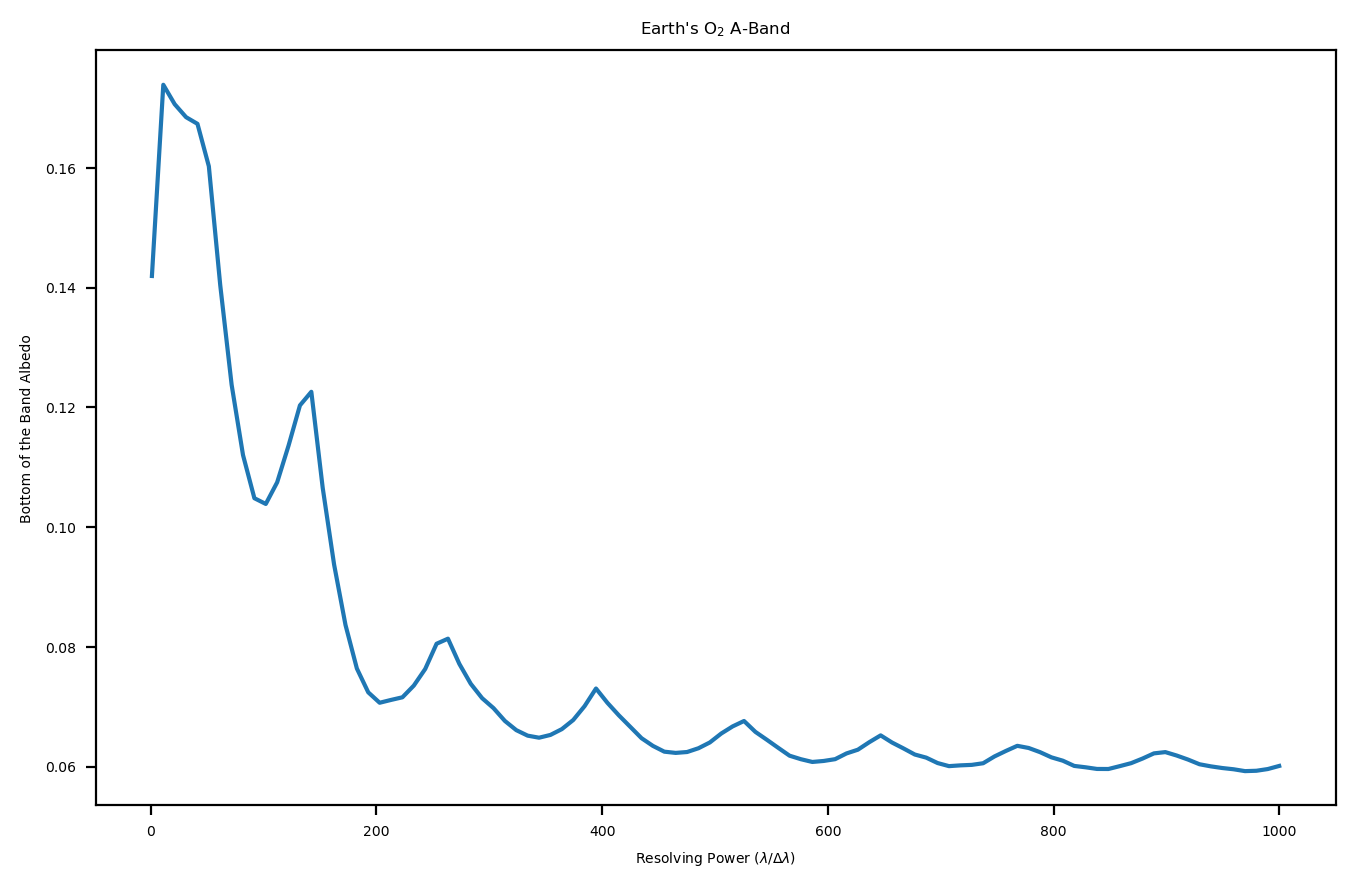

In [404]:

# Create resolution array to loop over
Nres = 100
R = np.linspace(1,1000,Nres)

# R = np.arange(70, 190, 20)
Nres = len(R)
# Array to store bottom-of-band albedos
bottom_val = np.zeros(len(R))

# Loop over R
for i, r in enumerate(R):

    # Construct new low-res wavelength grid
    if ifs:
        wl, dwl = construct_lam_ifs(lammin, lammax, r, verbose=False)
#         print(wl.size, dwl.size)
        Alr = downbin_spec_ifs(lam, dwl, albedo)
    else:                               
        # Construct new low-res wavelength grid
        wl, dwl = construct_lam(lammin, lammax, r)
        #     print(wl)
        # Down-bin flux to low-res
        Alr = downbin_spec(albedo,lam, wl, dlam=dwl)

    # Save bottom value
    bottom_val[i] = np.min(Alr)


# Make plot
plt.plot(R, bottom_val);
plt.xlabel(r"Resolving Power ($\lambda / \Delta \lambda$)")
plt.ylabel("Bottom of the Band Albedo")
plt.title(r"Earth's O$_2$ A-Band")
plt.show()

In [405]:
# Create resolution array to loop over
Nres = 100
Rmin = 50
Rmax = 500
R = np.linspace(Rmin, Rmax, Nres)
lamref =lam[m][albedo[m].argmin()]# 760.0
R = np.arange(70, 190, 20)
Nres = len(R)
# Set number of initial positions
Ntest = 200

# Arrays to save quantities
bottom_vals = np.nan*np.zeros([len(R), Ntest])
best = np.nan*np.zeros(len(R), dtype=int)
Alrs = []
lams = []

# Loop over R
for i, r in enumerate(R):
#     if r % 100 == 0:
#         print(r)
    # Set grid of minimum wavelengths to iterate over
    lammin_vals = np.linspace(lammin - lamref/r, lammin, Ntest)
#     lammin_vals = np.linspace(lammin - lamref/r/2, lammin, Ntest)
#     print(lammin_vals)

    # Loop over minimum wavelengths to adjust bin centers
    for j, lmin in enumerate(lammin_vals):

        if ifs:
            wl, dwl = construct_lam_ifs(lmin, lammax, r, verbose=False)
#             print(wl.size, dwl.size)
            Alr = downbin_spec_ifs(lam, dwl, albedo)
        else:                               
            # Construct new low-res wavelength grid
            wl, dwl = construct_lam(lmin, lammax, r)
            #     print(wl)
            # Down-bin flux to low-res
            Alr = downbin_spec(albedo,lam, wl, dlam=dwl)

        # Keep track of the minimum
        is_best = ~np.isfinite(best[i]) or (np.nansum(np.min(Alr) < bottom_vals[i,:]) > 0)
 
        if is_best:
            best[i] = j

        # Save quantities
        bottom_vals[i,j] = np.min(Alr)
        Alrs.append(Alr)
        lams.append(wl)
#     print(wl)
# Reshape saved arrays
Alrs = np.array(Alrs).reshape((Ntest, Nres), order = 'F')
lams = np.array(lams).reshape((Ntest, Nres), order = 'F')
best =  np.array(best, dtype=int)

<ipython-input-405-50e99f5de71f>:53: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  Alrs = np.array(Alrs).reshape((Ntest, Nres), order = 'F')
<ipython-input-405-50e99f5de71f>:54: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  lams = np.array(lams).reshape((Ntest, Nres), order = 'F')


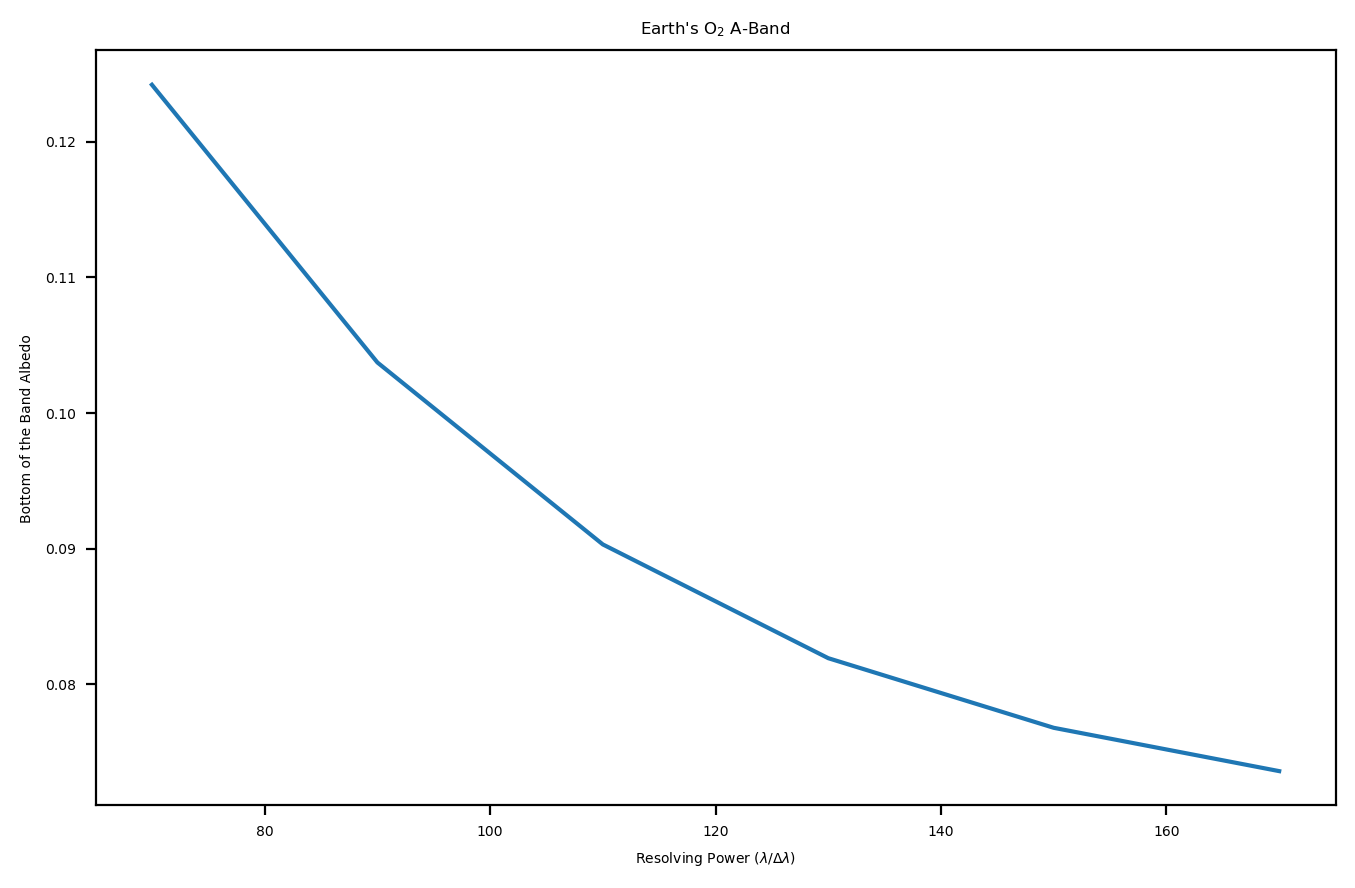

In [406]:
# Plot the global minimum
plt.plot(R, np.min(bottom_vals, axis = 1));
plt.xlabel(r"Resolving Power ($\lambda / \Delta \lambda$)")
plt.ylabel("Bottom of the Band Albedo")
# plt.xlim([100, 500])
plt.title(r"Earth's O$_2$ A-Band");

[0 0 1 1 2 3 4 5 7 9]
70 684.0 846.1760564462721
90 684.0 843.7909760101065
110 684.0 842.2729535573886
130 684.0 841.2219033871396
150 684.0 840.4510751227109
170 684.0 839.8615849653182


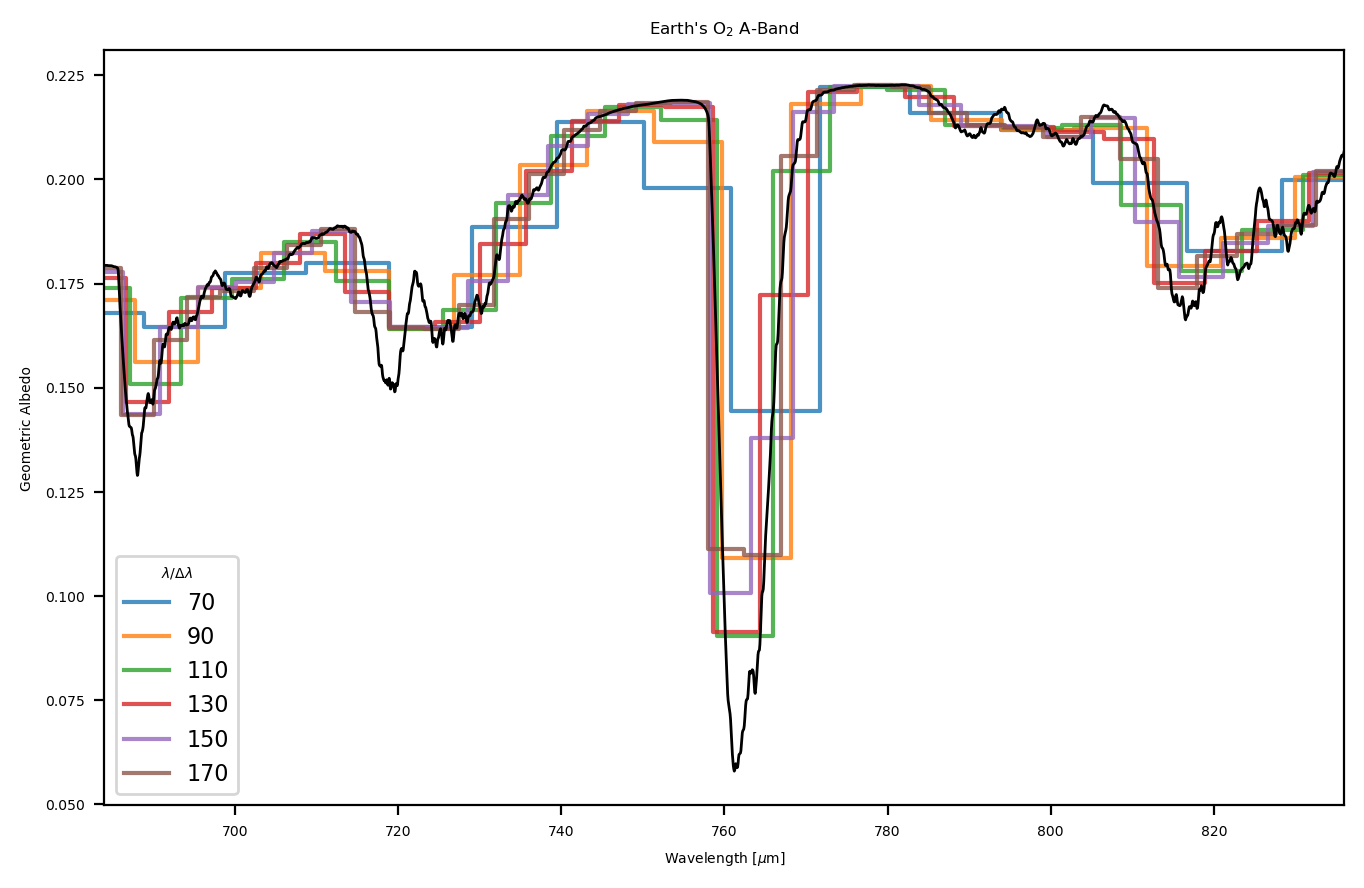

In [407]:
# Get some log-spaced indices so we're not plotting all R
iz = np.array(np.logspace(np.log10(1), np.log10(10), 10).round(), dtype=int) - 1
print(iz)

colors = [f'C{i}' for i in range(iz.size)]#
# colors = plt.cm.jet(np.linspace(0,1, iz.size))
# Loop over R
count = 0
for i, r in enumerate(R):

    
    # Plot some of the resolutions
    if i in iz:
        
        wlens = lams[best[i], i]
        alb = Alrs[best[i], i]
        
        plt.plot(wlens, alb,  drawstyle='steps-mid', alpha = 0.8, color=colors[count], label=f'{int(r)}')
        print(r,wlens.min(), wlens.max())
        count +=1
#         plt.scatter(wl, Alr, color=f"C{i}")
#         plt.plot(lams[best[i], i], Alrs[best[i], i], ls = "steps-mid", alpha = 0.5, label = "%i" %r)


# Finsh plot
plt.plot(lam[m], albedo[m], c = "k", lw=1)
plt.legend(fontsize = 8, title = r"$\lambda / \Delta \lambda$")
plt.xlabel(r"Wavelength [$\mu$m]")
plt.ylabel("Geometric Albedo")
# plt.xlim(750, 775)
# plt.xlim(lammin, lammax)
plt.xlim(684, 836)
# plt.axvline(719)
plt.title(r"Earth's O$_2$ A-Band");

In [195]:
lam[albedo[m].min()]

IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

In [199]:
lam[m][albedo[m].argmin()]
    lammin = 680
    lammax = 840
    lamref = lam[m][albedo[m].argmin()]

761.2090000000001

In [350]:
def optimize_wavelength_grid(x, r):
    R = 70
#     wl, dwl = construct_lam(x, lammax, r)
#     #             print(wl.size, dwl.size)
#     Alr = downbin_spec(lam, dwl, albedo)
    
    wl, dwl = construct_lam(x, lammax, r)
    #     print(wl)
    # Down-bin flux to low-res
    Alr = downbin_spec(albedo,lam, wl, dlam=dwl)
#     print(np.min(Alr))
    return np.min(Alr)

In [332]:
from scipy.optimize import minimize

In [238]:
minimize(optimize_wavelength_grid,681.4, bounds=((675.5, 690.0),))

      fun: 0.12238628632238484
 hess_inv: <1x1 LbfgsInvHessProduct with dtype=float64>
      jac: array([0.])
  message: 'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 2
      nit: 0
     njev: 1
   status: 0
  success: True
        x: array([681.4])

In [420]:
# x = np.linspace(lammin-lam[m][albedo[m].argmin()]/150, lammin+10, 50)

r_test = 300
x = np.linspace(lammin - lammin/r_test, lammin+lammin/r_test,120)
res = list(map(lambda a: optimize_wavelength_grid(a, r_test), x))

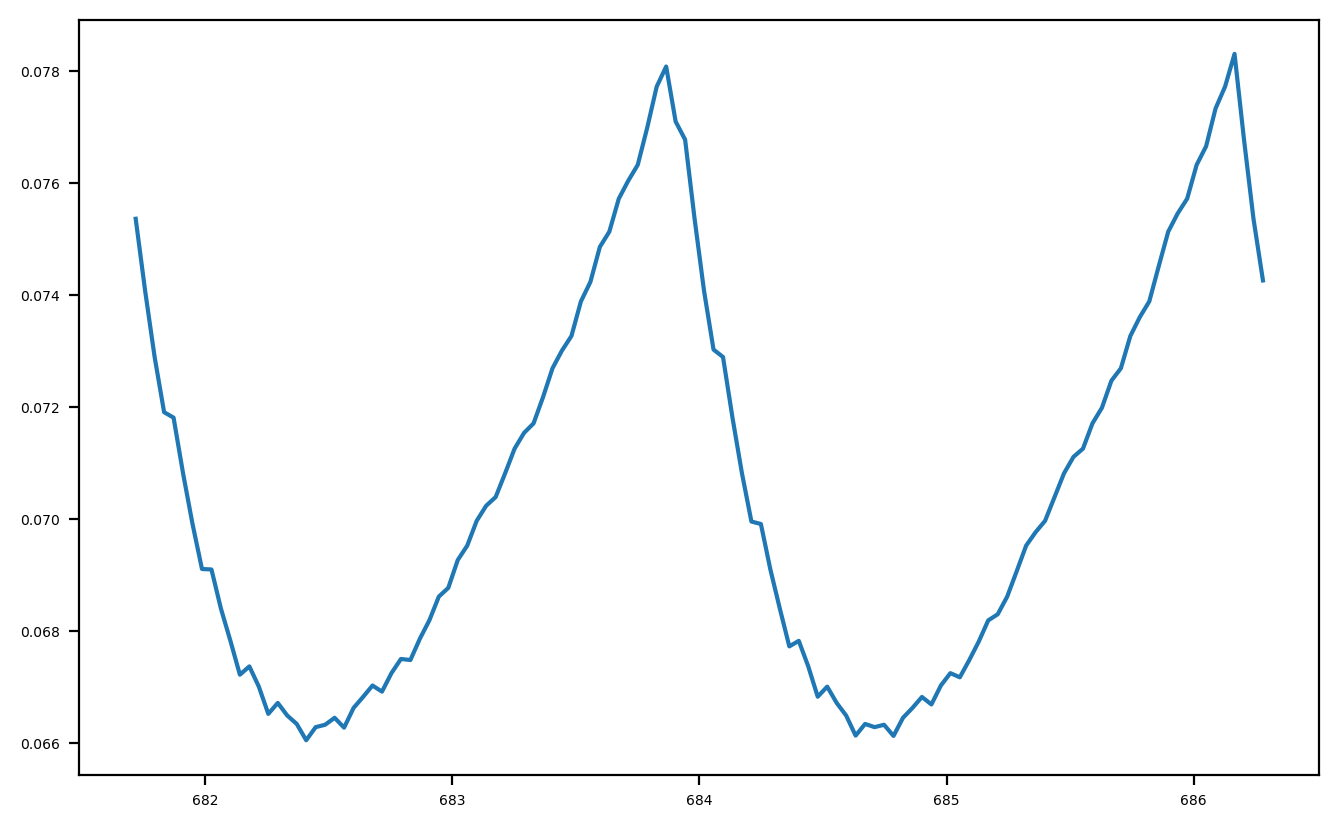

In [421]:
plt.plot(x, res)

In [422]:
x[np.argmin(res)]

682.4097478991597

In [423]:
wl, dwl = construct_lam(x[np.argmin(res)], 836, 150)

Alr = downbin_spec(albedo,lam, wl, dlam=dwl)

In [426]:
# wl, dwl = construct_lam(lmin, lammax, r)
wl, dwl = construct_lam(x[np.argmin(res)], 836,300)
#     print(wl)
# Down-bin flux to low-res
Alr = downbin_spec(albedo, lam, wl, dlam=dwl)

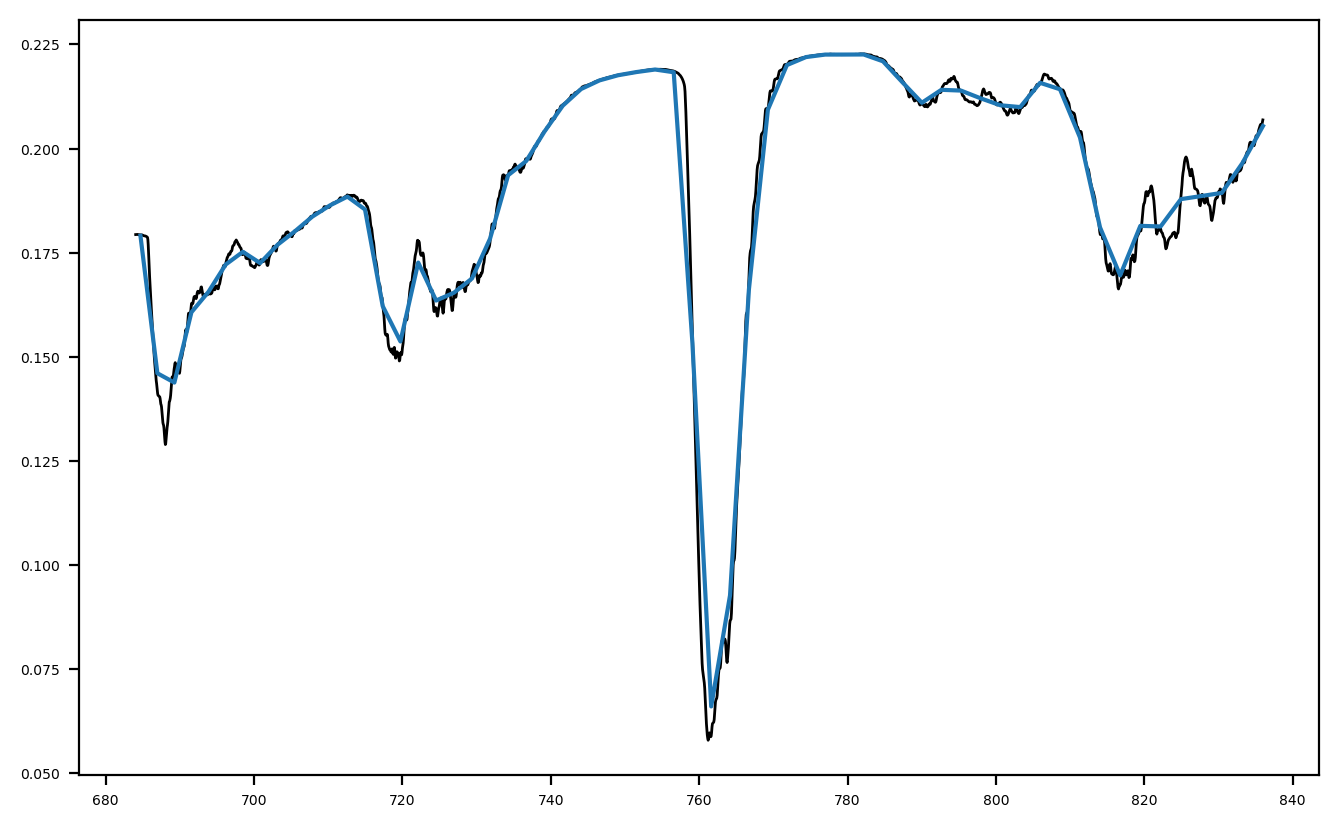

In [427]:
plt.plot(lam[m], albedo[m], c = "k", lw=1)
plt.plot(wl[1:-1], Alr[1:-1])

50 664.7673469387755 843.0857330482149 49.99999999999997
100 683.6897959183674 842.5737941875865 100.0
150 680.8979591836735 836.6395056210208 149.9999999999999
200 679.5020408163265 837.8482351650628 199.99999999999986
250 678.5404081632653 838.4216698694704 250.00000000000082
300 680.1741496598639 836.036149825873 299.9999999999989


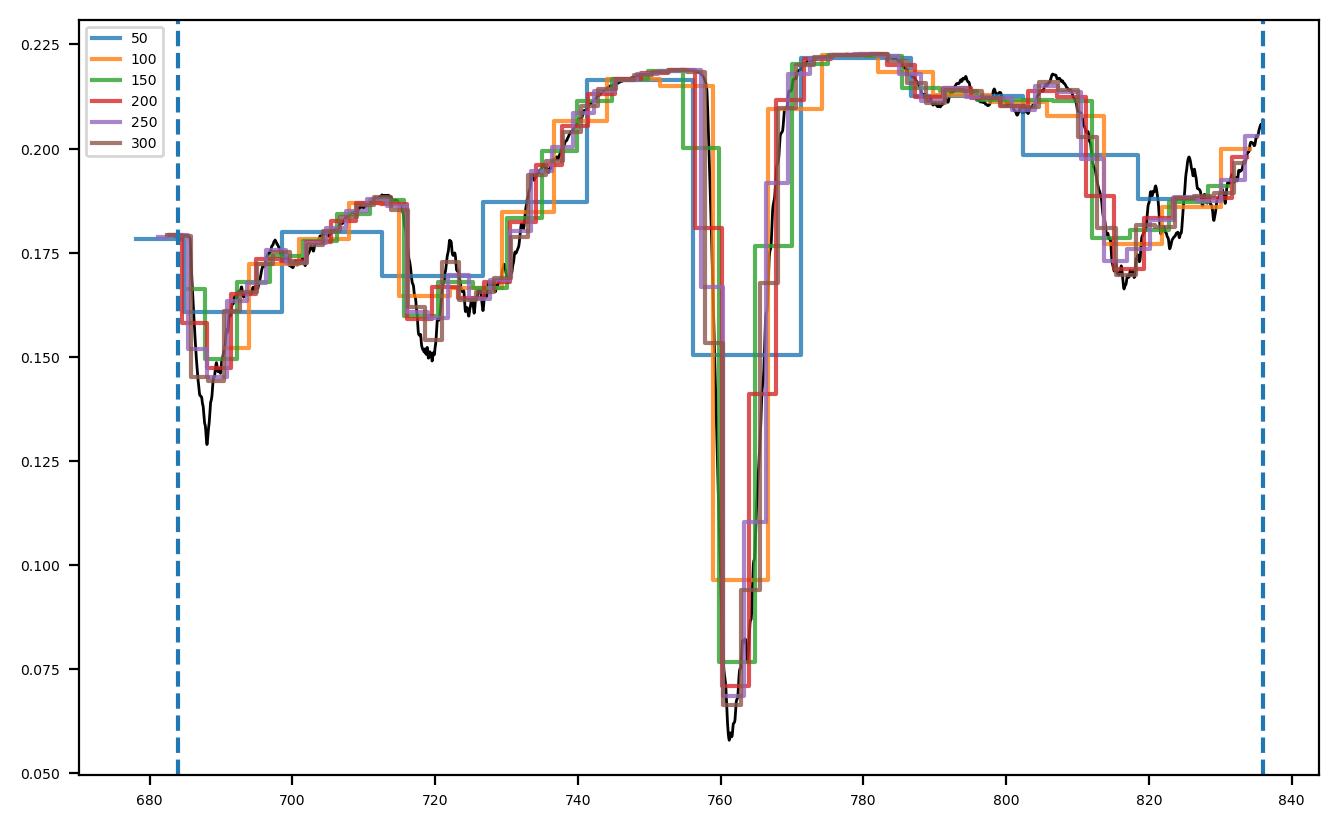

In [413]:
plt.plot(lam[m], albedo[m], c = "k", lw=1)
R_list = np.arange(50, 300+50, 50)
for r in R_list:
    x = np.linspace(lammin - 2*760/r, lammin, 50)
    
    res = list(map(lambda a: optimize_wavelength_grid(a, r), x))
#     plt.figure()
#     plt.plot(x, res)
#     plt.show()
    wl, dwl = construct_lam(x[np.argmin(res)], 836,r)
    print(r, wl.min(), wl.max(), np.mean(wl[:-1] / np.diff(wl)))
    Alr = downbin_spec(albedo, lam, wl, dlam=dwl)
    
#     plt.plot(wl[1:-1], Alr[1:-1])
    plt.plot(wl[1:-1], Alr[1:-1],  drawstyle='steps-mid', alpha = 0.8,  label=f'{int(r)}')
    
plt.legend()
plt.axvline(684, ls='--')
plt.axvline(836, ls='--')
plt.show()

In [298]:
wl.size

32

In [349]:
def optimize_wavelength_grid(x, r):
    R = 150
    wl, dwl = construct_lam_ifs(x, lammax, r, verbose=False)
    #             print(wl.size, dwl.size)
    Alr = downbin_spec(lam, dwl, albedo)
#     print(np.min(Alr))
    return np.min(Alr)

In [359]:
for r in R:
#     x = np.linspace(lammin-lam[m][albedo[m].argmin()]/r, lammin+10, 50)
    
    # wl, dwl = construct_lam(lmin, lammax, r)
    wl, dwl = construct_lam(x[np.argmin(res)], 836, 150)
    #     print(wl)
    # Down-bin flux to low-res
    Alr = downbin_spec(albedo, lam, wl, dlam=dwl)